In [20]:
!pip install neptune


In [43]:
import os
from getpass import getpass
import neptune

# Enter your Neptune API token manually
api_token = getpass("Enter your Neptune API token: ")

# Initialize Neptune run
run = neptune.init_run(
    project="e20376/CO542-PROJECT",
    api_token=api_token  # Directly pass the API token here
)



Enter your Neptune API token: ··········
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/e20376/CO542-PROJECT/e/COP-6


In [45]:
import kagglehub
import os
import zipfile

# Download MusicNet( this contains classical music)
musicnet_path = kagglehub.dataset_download("imsparsh/musicnet-dataset")

print("Path to dataset files:", musicnet_path)

#GTZAN(non-classical dataset,small amont of classical also)
non_classical_path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", non_classical_path)


Path to dataset files: /root/.cache/kagglehub/datasets/imsparsh/musicnet-dataset/versions/1
Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [49]:
#to explaore dataset folders and find audio file paths
import os
import pandas as pd


print("MusicNet Directory Structure:")
print(os.listdir(musicnet_path+"/musicnet/musicnet"))  # Shows the folder contents


import os

print("non classical Directory Structure:")
print(os.listdir(non_classical_path+"/Data/"))  # Shows the folder contents

#genre original
print("genre original fold")
print(os.listdir(non_classical_path+"/Data/genres_original"))  # Shows the folder contents

#see labels
print("MusicNet train labels Directory Structure:")
print(os.listdir(musicnet_path+"/musicnet/musicnet/train_labels"))

df = pd.read_csv(musicnet_path+"/musicnet/musicnet/train_labels/2238.csv")
#print(df.head())

MusicNet Directory Structure:
['test_labels', 'test_data', 'train_data', 'train_labels']
non classical Directory Structure:
['genres_original', 'images_original', 'features_3_sec.csv', 'features_30_sec.csv']
genre original fold
['rock', 'metal', 'disco', 'hiphop', 'classical', 'pop', 'blues', 'country', 'jazz', 'reggae']
MusicNet train labels Directory Structure:
['1775.csv', '2391.csv', '2166.csv', '2632.csv', '1813.csv', '2555.csv', '2472.csv', '1756.csv', '1749.csv', '2393.csv', '1791.csv', '2238.csv', '2243.csv', '2488.csv', '2487.csv', '2371.csv', '2431.csv', '2377.csv', '1752.csv', '2497.csv', '2423.csv', '2381.csv', '2523.csv', '2550.csv', '2177.csv', '2621.csv', '2383.csv', '2195.csv', '2420.csv', '2608.csv', '2406.csv', '2297.csv', '2240.csv', '2330.csv', '2077.csv', '1829.csv', '2502.csv', '2294.csv', '2403.csv', '2620.csv', '1790.csv', '2194.csv', '2202.csv', '2528.csv', '2397.csv', '2079.csv', '2104.csv', '1742.csv', '1923.csv', '2105.csv', '2483.csv', '2358.csv', '1755.csv

In [50]:
print("MusicNet sample files:", os.listdir(musicnet_path)[:5])  #  .wav audio file names
print("GTZAN sample files:", os.listdir(non_classical_path)[:5])  #genre folder names


MusicNet sample files: ['musicnet_metadata.csv', 'musicnet.npz', 'musicnet_midis', 'musicnet']
GTZAN sample files: ['Data']


In [48]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

def extract_features(audio_path, label):
    #Extracts MFCC features from an audio file.(mel frequency cepstral coefficients)
    try:
        y, sr = librosa.load(audio_path, sr=22050)  # Load audio file >>>>   here sr = sample rate , y= data
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)  # Extract MFCC features (time and f dependent)

        # Pad or resize to ensure a valid input size for CNN
        mfccs = np.pad(mfccs, ((0, 0), (0, 50)), mode='constant', constant_values=0)
        #mfccs = np.mean(mfccs, axis=1)  # mean across time axis
        return mfccs, label
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None, None

# Process classical music (MusicNet)
musicnet_audio_dir = os.path.join(musicnet_path, "musicnet/musicnet/train_data")
classical_data = []   #store features data


if os.path.exists(musicnet_audio_dir):
  for file in tqdm(os.listdir(musicnet_audio_dir)):
    #print("executin musicnet audio dir")
    if file.endswith(".wav"):
          filepath = os.path.join(musicnet_audio_dir, file)
          #print(f"Processing {filepath}")
          features, label = extract_features(filepath, label=1)  # 1 = classical

          if features is not None:
              classical_data.append(features)   #str features in the list
          else:
                print(f"Failed to extract features from {filepath}")  # Debug output
else:
    print(f"MusicNet directory not found: {musicnet_audio_dir}")


#print the number of features extracted
print(f"Classical data features: {len(classical_data)}")


100%|██████████| 320/320 [06:35<00:00,  1.24s/it]

Classical data features: 320


In [29]:
# Process non-classical music (GTZAN)
gtzan_audio_dir = os.path.join(non_classical_path+"/Data", "genres_original")
non_classical_data = []


if os.path.exists(gtzan_audio_dir):
  for genre in os.listdir(gtzan_audio_dir):   #going to sub folders      #'rock', 'jazz', 'disco',...

    print(genre)

    if genre == "classical":
      print("\nskipping classical\n")
      continue      #skip classical data in this because classical data obtained from musicnet dataset
    #print("executing gtzan audio dir

    genre_path = os.path.join(gtzan_audio_dir, genre) #open genre fold
    count =0    #limit the non classical data
    #that is to make the classical and non classical training data to be equally used.

    for file in tqdm(os.listdir(genre_path)):
        #print("executing gtzan audio dir")

        if file.endswith(".wav") and count <40:   #use audio files only
              filepath = os.path.join(genre_path, file)
              features, label = extract_features(filepath, label=0)  # 0 = non-classical

              if features is not None:
                  non_classical_data.append(features)   #str features
                  count+=1
              else:
                  print(f"Failed to extract features from {filepath}")  # Debug output
else:
    print(f"GTZAN directory not found: {gtzan_audio_dir}")

print(f"Non-classical data features: {len(non_classical_data)}")

rock


100%|██████████| 100/100 [00:03<00:00, 29.31it/s]


metal


100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


disco


100%|██████████| 100/100 [00:03<00:00, 31.17it/s]


hiphop


100%|██████████| 100/100 [00:03<00:00, 32.13it/s]


classical

skipping classical

pop


100%|██████████| 100/100 [00:03<00:00, 25.55it/s]


blues


100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


country


100%|██████████| 100/100 [00:03<00:00, 32.47it/s]


jazz


100%|██████████| 100/100 [00:03<00:00, 32.79it/s]


reggae


100%|██████████| 100/100 [00:04<00:00, 23.74it/s]

Non-classical data features: 360


In [ ]:
#print(classical_data)

In [30]:
import numpy as np
from sklearn.utils import shuffle


#fixed length for MFCC arrays (get rid of music length changes)
fixed_length = 130

# Pad or truncate each MFCC feature array to the fixed length
def pad_or_truncate_mfcc(mfcc, fixed_length=130):
    # If the length is shorter ->>> pad with zeros
    if mfcc.shape[1] < fixed_length:
        mfcc = np.pad(mfcc, ((0, 0), (0, fixed_length - mfcc.shape[1])), mode='constant')
    # If the length is longer >>>> truncate
    else:
        mfcc = mfcc[:, :fixed_length]
    return mfcc

#handle empty data
if len(classical_data)==0 or len(non_classical_data)==0:
  raise ValueError("Empty data in classical_data or non_classical_data")


# Apply padding/truncation to all data
classical_data = [pad_or_truncate_mfcc(mfcc) for mfcc in classical_data]
non_classical_data = [pad_or_truncate_mfcc(mfcc) for mfcc in non_classical_data]

# make as NumPy arrays
classical_data = np.array(classical_data)  # Should be a list of Mel Spectrograms
non_classical_data = np.array(non_classical_data)

#  1 << classical, 0 << non-classical
classical_labels = np.ones(len(classical_data))  # [1,1,1,...]
non_classical_labels = np.zeros(len(non_classical_data))  # [0,0,0,...]

# Combine features and labels
features = np.concatenate((classical_data, non_classical_data), axis=0)
labels = np.concatenate((classical_labels, non_classical_labels), axis=0)

# Shuffle data
features, labels = shuffle(features, labels, random_state=42)

# Ensure features have the correct shape for CNN input (Add channel dimension)
features = features[..., np.newaxis]  # Shape: (samples, height, width, channels)

# Convert labels to integer type
labels = labels.astype(int)

print(f"Features shape: {features.shape}")  # Should be (num_samples, height, width, 1)
print(f"Labels shape: {labels.shape}")  # Should be (num_samples,)


Features shape: (680, 20, 130, 1)
Labels shape: (680,)


In [31]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Standardization: Normalize each spectrogram to mean=0, std=1
mean_train = np.mean(X_train, axis=(1, 2), keepdims=True)
std_train = np.std(X_train, axis=(1, 2), keepdims=True)
X_train = (X_train - mean_train) / np.where(std_train == 0, 1, std_train)  # Avoid division by zero

mean_test = np.mean(X_test, axis=(1, 2), keepdims=True)
std_test = np.std(X_test, axis=(1, 2), keepdims=True)
X_test = (X_test - mean_test) / np.where(std_test == 0, 1, std_test)  # Avoid division by zero



Training data shape: (544, 20, 130, 1)
Testing data shape: (136, 20, 130, 1)


In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((3,3)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((3,3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (classical vs. non-classical)
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Save model
model.save("music_classification_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8141 - loss: 0.4051 - val_accuracy: 0.9853 - val_loss: 0.0344
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9604 - loss: 0.0970 - val_accuracy: 1.0000 - val_loss: 0.0183
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9647 - loss: 0.0887 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9868 - loss: 0.0379 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9915 - loss: 0.0257 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9925 - loss: 0.0329 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9853 - loss: 0.0356 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9979 - loss: 0.0166 - val_accuracy: 1.0000 - v

Test Accuracy: 1.0000


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0040
Test Accuracy: 1.0000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


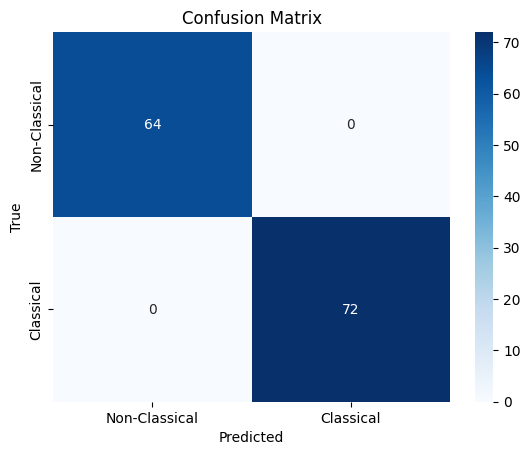

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        72

    accuracy                           1.00       136
   macro avg       1.00      1.00      1.00       136
weighted avg       1.00      1.00      1.00       136



In [52]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Classical', 'Classical'], yticklabels=['Non-Classical', 'Classical'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


In [53]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model("music_classification_model.h5")

# Check the model summary
loaded_model.summary()

#evaluate model
test_loss, test_acc = loaded_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 18, 128, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 42, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 40, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 13, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 832)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │         106,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,571 (490.52 KB)

 Trainable params: 125,569 (490.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0040
Test Accuracy: 1.0000


In [54]:
import sys

audio_path = gtzan_audio_dir+"/classical/classical.00002.wav"
#musicnet_test_audio_dir
audio_path = os.path.join(musicnet_path, "musicnet/musicnet/test_data")
#print(os.listdir(musicnet_dir))

#audio_path = musicnet_audio_dir+"/classical/00001.wav"
if os.path.exists(audio_path):
  print(f"Audio file found: {audio_path}")
else:
  print(f"Audio file not found: {audio_path}")
  sys.exit("Exiting, file not found!")

def extract_mfcc(audio_path, sr=22050, n_mfcc=20, max_length=130):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=sr)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Pad or truncate MFCC to the fixed length
    if mfcc.shape[1] < max_length:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_length]

    return mfcc

audio_files = os.listdir(audio_path)
#print(audi0_files)


# Extract MFCCs
for audio_file in audio_files:
    audio_pathnew = os.path.join(audio_path, audio_file)
    print(f"Processing {audio_pathnew}")

    if audio_file.endswith(".wav") and os.path.isfile(audio_pathnew):

      mfcc = extract_mfcc(audio_pathnew)

      # Standardize the MFCC (use the mean and std of the training set)
      mean_train = np.mean(X_train, axis=(1, 2), keepdims=True)
      std_train = np.std(X_train, axis=(1, 2), keepdims=True)
      mfcc = (mfcc - mean_train) / np.where(std_train == 0, 1, std_train)

      # Check shape of mfcc
      #print("MFCC Shape:", mfcc.shape)

      #Reshape for model input (add batch dimension)
      #mfcc = np.expand_dims(mfcc, axis=0)  # Shape: (1, 20, 130, 1)
      #Reshape for model input (add batch dimension and channel dimension)
      mfcc = np.expand_dims(mfcc, axis=0)  # Add batch dimension -> Shape: (1, 20, 130)
      mfcc = np.expand_dims(mfcc, axis=-1)  # Add channel dimension -> Shape: (1, 20, 130, 1)

      #print("Reshaped MFCC Shape:", mfcc.shape)

      # Remove unwanted dimensions by squeezing unnecessary axes
      mfcc = np.squeeze(mfcc)

      #print("Reshaped MFCC Shape:", mfcc.shape)
      #print(mfcc)
      # Make prediction
      prediction = loaded_model.predict(mfcc)

      # Convert prediction to binary label
      predicted_label = (prediction > 0.5).astype(int)


      # Print the predicted label
      if predicted_label[0] == 1:
          print("Predicted: Classical music")
      else:
          print("Predicted: Non-classical music")

    else:
        # Skip directories or non-wav files
        if os.path.isdir(audio_path):
            print(f"Skipping directory: {audio_path}")
        else:
            print(f"Skipping non-audio file: {audio_path}")

Audio file found: /root/.cache/kagglehub/datasets/imsparsh/musicnet-dataset/versions/1/musicnet/musicnet/test_data
Processing /root/.cache/kagglehub/datasets/imsparsh/musicnet-dataset/versions/1/musicnet/musicnet/test_data/2303.wav
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted: Classical music
Processing /root/.cache/kagglehub/datasets/imsparsh/musicnet-dataset/versions/1/musicnet/musicnet/test_data/2382.wav
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted: Classical music
Processing /root/.cache/kagglehub/datasets/imsparsh/musicnet-dataset/versions/1/musicnet/musicnet/test_data/2628.wav
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted: Classical music
Processing /root/.cache/kagglehub/datasets/imsparsh/musicnet-dataset/versions/1/musicnet/musicnet/test_data/1819.wav
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted: Classical music
Processing /root/.cache/kagglehub/datasets/imsparsh/musicnet-dataset/versions/1/musicnet/musicnet/test_data/2106.wav
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Log additional hyperparameters
run["parameters/learning_rate"] = 0.001
run["parameters/batch_size"] = 32
run["parameters/epochs"] = 20

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Log training metrics
for epoch in range(20):
    run["train/loss"].log(history.history['loss'][epoch])
    run["train/accuracy"].log(history.history['accuracy'][epoch])
    run["val/loss"].log(history.history['val_loss'][epoch])
    run["val/accuracy"].log(history.history['val_accuracy'][epoch])

# Evaluate model performance
y_pred = (model.predict(X_test) > 0.5).astype("int32")

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Log additional metrics
run["test/precision"] = precision
run["test/recall"] = recall
run["test/f1_score"] = f1
run["test/confusion_matrix"] = str(conf_matrix)  # Convert to string to store in Neptune

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

# Stop Neptune run
run.stop()


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9933 - loss: 0.0168 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9965 - loss: 0.0194 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9984 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9939 - loss: 0.0112 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9961 - loss: 0.0151 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9979 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 1.

In [61]:
from itertools import product
import neptune
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
import getpass  # Securely get user input

# Get Neptune API token from user input
NEPTUNE_API_TOKEN = getpass.getpass("Enter your Neptune API token: ")

# Define Hyperparameters
learning_rates = [0.001, 0.0005]
batch_sizes = [32, 64]
dropout_rates = [0.3, 0.4]

# Iterate over all combinations of hyperparameters
for lr, bs, dr in product(learning_rates, batch_sizes, dropout_rates):
    with neptune.init_run(
        project="e20376/CO542-PROJECT",
        api_token=NEPTUNE_API_TOKEN
    ) as run:

        # Log parameters
        params = {"learning_rate": lr, "batch_size": bs, "dropout_rate": dr}
        run["parameters"] = params

        # Define Model
        model = Sequential([
            Input(shape=(20, 130, 1)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(dr),
            Dense(64, activation='relu'),
            Dropout(dr),
            Dense(1, activation='sigmoid')
        ])

        # Compile Model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Train Model
        history = model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=bs,
            validation_data=(X_test, y_test),
            verbose=1
        )

        # Log training metrics
        for epoch in range(20):
            run["train/loss"].log(history.history['loss'][epoch])
            run["train/accuracy"].log(history.history['accuracy'][epoch])
            run["val/loss"].log(history.history['val_loss'][epoch])
            run["val/accuracy"].log(history.history['val_accuracy'][epoch])

        # Evaluate Model
        eval_result = model.evaluate(X_test, y_test, verbose=1)
        run["test/loss"] = eval_result[0]
        run["test/accuracy"] = eval_result[1]

print("✅ Training complete!")


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/e20376/CO542-PROJECT/e/COP-10
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7606 - loss: 0.5238 - val_accuracy: 0.9926 - val_loss: 0.0306
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9190 - loss: 0.2277 - val_accuracy: 0.9926 - val_loss: 0.0247
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9689 - loss: 0.1149 - val_accuracy: 0.9926 - val_loss: 0.0160
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9807 - loss: 0.0607 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9755 - loss: 0.0561 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9826 - loss: 0.0569 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9900 - loss: 0.0559 - val_accuracy: 1.0000 - val_loss: 0.0140


In [59]:
print(X_train.shape)
print(y_train.shape)



(544, 20, 130, 1)
(544,)
